In [1]:
import pandas as pd
import  duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

%load_ext autoreload
from duckdb_flow.etl import preprocess_data, get_processed_files
from duckdb_flow.create_database import create_database

The autoreload module is not an IPython extension.


In [2]:
STAGING_PATH = "./data"
DATABASE_PATH = "./database/DDBB_duckdb.duckdb"

In [3]:
create_database()

'Database Created'

In [4]:
processed_files = get_processed_files()
movies_df, directing_data, writing_data  = preprocess_data(processed_files)

Created  directing_df  dataframe.
Appending:  963  rows...
Appending:  993  rows...
Appending:  951  rows...
Appending:  1049  rows...
Appending:  974  rows...
Appending:  1001  rows...
Appending:  1035  rows...
Appending:  993  rows...
Created  writing_df  dataframe.


In [5]:
STAGING_PATH = "./data"
DATABASE_PATH = "./database/DDBB_duckdb.duckdb"

## EDA

### Movies

In [6]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
movies = con.execute('''select * from movies''').fetch_df()
movies.shape
con.close()

In [8]:
movies[movies["label"] == False]

movie_id         primary_title     original_title  start_year  \
6     tt0021015  juno and the paycock                nan        1929   
26    tt0035009       the mad monster                nan        1942   
28    tt0036716           cobra woman        cobra woman        1944   
38    tt0040626     my dear secretary  my dear secretary        1948   
56    tt0046248         robot monster      robot monster        1953   
...         ...                   ...                ...         ...   
7949  tt9347730              candyman                nan        2021   
7953  tt9624766             jiu jitsu                nan        2020   
7954  tt9625664         trauma center                nan        2019   
7955  tt9741310                 slaxx              slaxx        2020   
7956  tt9742392               kindred            kindred        2020   

      runtime_min  num_votes  label subset  title_changed  title_length  \
6              85       2275  False  train           True            20   
26             77       1720  False  train           True            15   
28             71       1101  False  train          False            11   
38             94       3526  False  train          False            17   
56             66       4924  False  train          False            13   
...           ...        ...    ...    ...            ...           ...   
7949           91      44515  False  train           True             8   
7953          102       7920  False  train           True             9   
7954           87      12951  False  train           True            13   
7955           77       2464  False  train          False             5   
7956          101       1719  False  train          False             7   

                  audit_time  
6    2024-03-08 16:47:30.585  
26   2024-03-08 16:47:30.585  
28   2024-03-08 16:47:30.585  
38   2024-03-08 16:47:30.585  
56   2024-03-08 16:47:30.585  
...                      ...  
7949 2024-03-08 16:47:30.585  
7953 2024-03-08 16:47:30.585  
7954 2024-03-08 16:47:30.585  
7955 2024-03-08 16:47:30.585  
7956 2024-03-08 16:47:30.585  

[3969 rows x 11 columns]

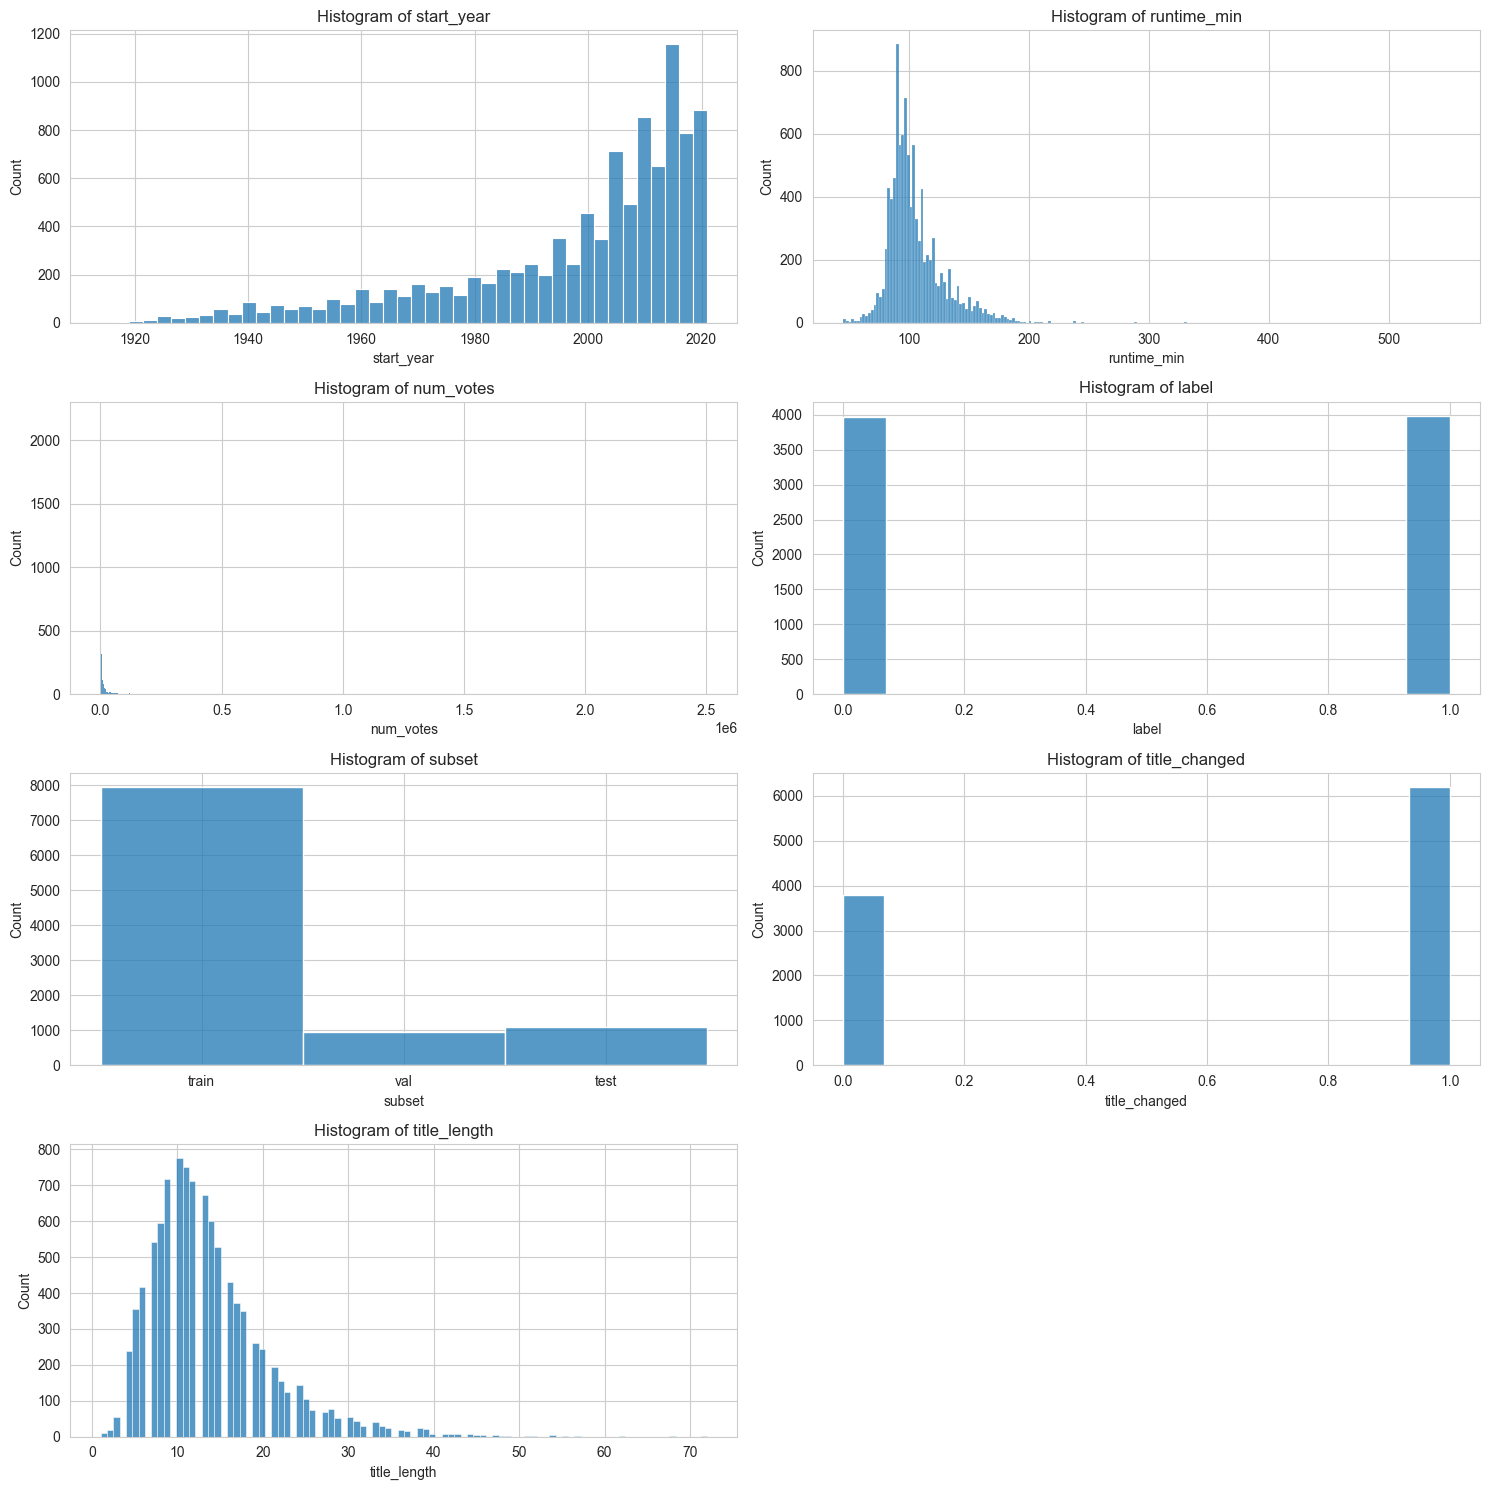

In [13]:
movie_cols = ['start_year', 'runtime_min', 'num_votes', 'label', 'subset', "title_changed", "title_length"]
num_cols = len(movie_cols)
num_rows = (num_cols + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 15))

axes = axes.flatten()

for i, column in enumerate(movie_cols):
    if column == 'num_votes':
        sns.histplot(movies[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')
    else:
        sns.histplot(movies[column], ax=axes[i])
        axes[i].set_title(f'Histogram of {column}')

for i in range(num_cols, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

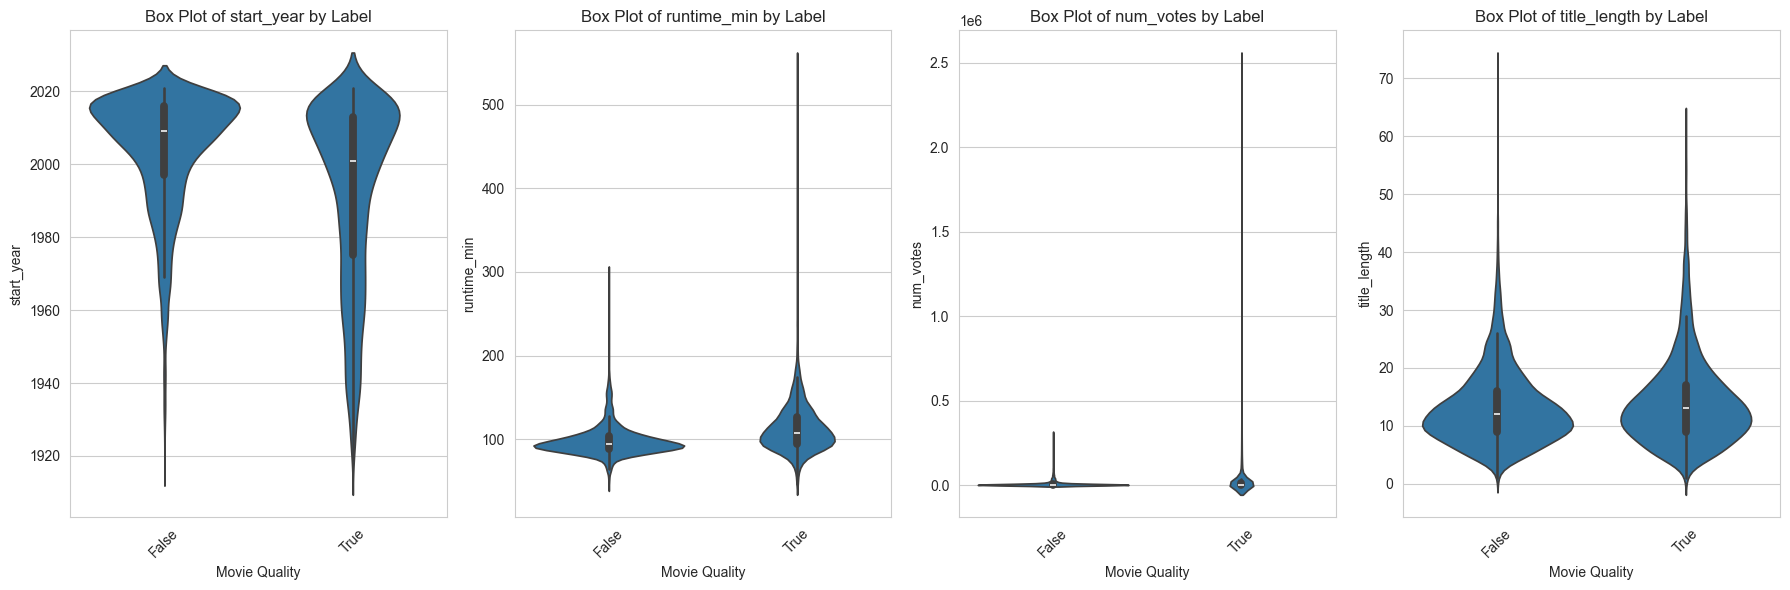

In [11]:

continuous_variables = ['start_year', 'runtime_min', 'num_votes', "title_length"]

fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, variable in enumerate(continuous_variables):
    sns.violinplot(x='label', y=variable, data=movies, ax=axes[i])
    axes[i].set_title(f'Box Plot of {variable} by Label')
    axes[i].set_xlabel('Movie Quality')
    axes[i].set_ylabel(variable)
    axes[i].tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

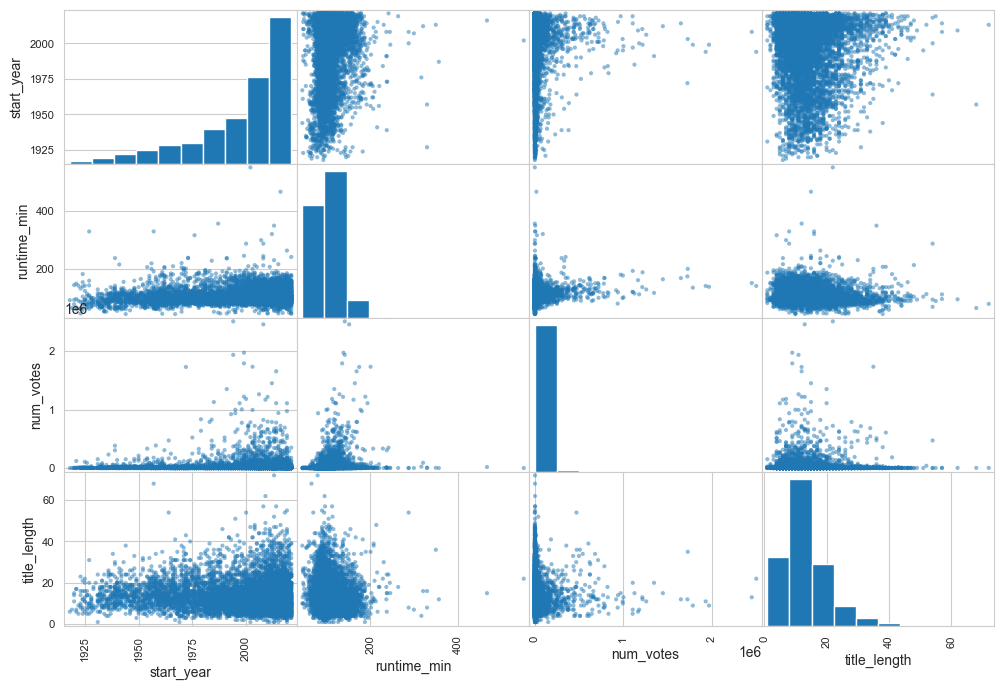

In [16]:
from pandas.plotting import scatter_matrix

scatter_matrix(movies[movies["subset"]=="train"][['start_year', 'runtime_min', 'num_votes', "title_length"]], figsize=(12, 8))
plt.show()

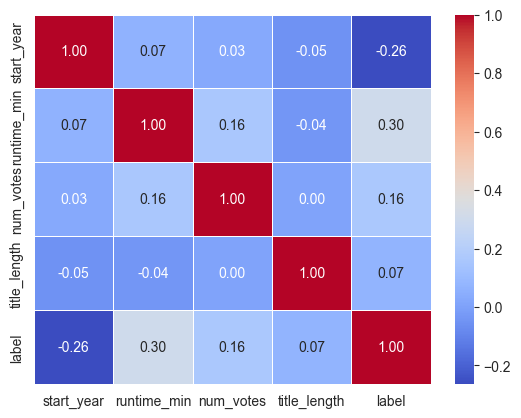

In [17]:
sns.heatmap(movies[movies["subset"]=="train"][['start_year', 'runtime_min', 'num_votes',"title_length", 'label']].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.show()

### Directors

In [13]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
directing = con.execute('''select * from directing''').fetch_df()
directing.shape
con.close()

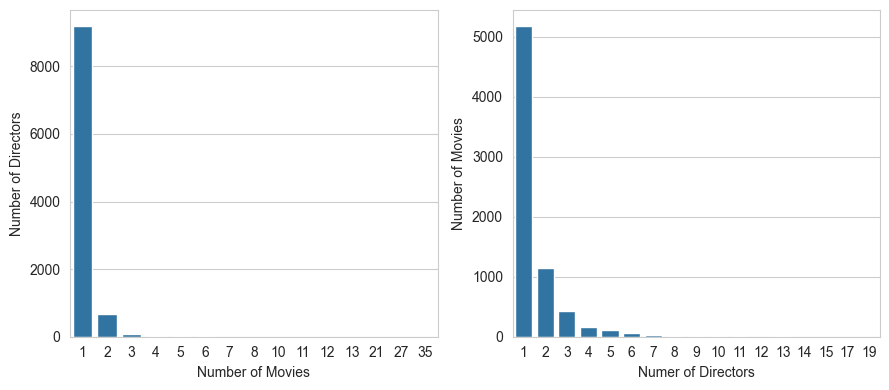

In [40]:
# Counting the number of directors per movie
director_counts = directing.groupby("movie_id").count()["director_id"].value_counts()
# Counting the number of movies directed by each director
movie_counts = directing.groupby("director_id").count()["movie_id"].value_counts()

# Creating a figure with two subplots
plt.figure(figsize=(9, 4))  

# Subplot 1: Distribution of movies directed by directors
plt.subplot(1, 2, 1)
sns.barplot(x=director_counts.index, y=director_counts.values)
plt.xlabel("Number of Movies")
plt.ylabel("Number of Directors")

plt.subplot(1, 2, 2)
sns.barplot(x=movie_counts.index, y=movie_counts.values)
plt.xlabel("Numer of Directors")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

### Writers

In [15]:
con = duckdb.connect(database=DATABASE_PATH, read_only=False)
writing = con.execute('''select * from writing''').fetch_df()
writing.shape
con.close()

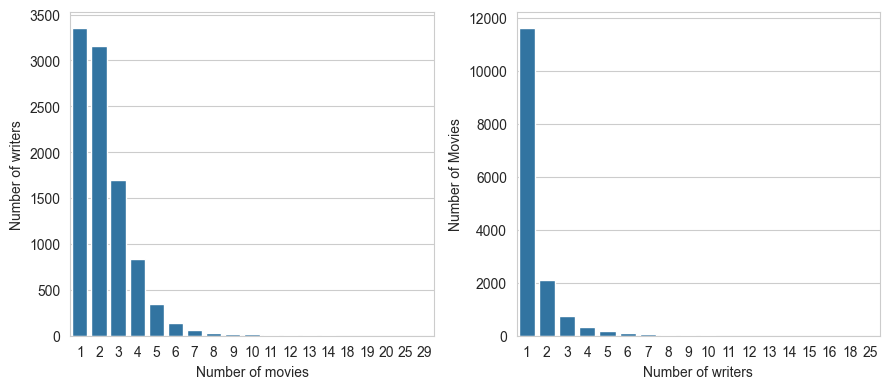

In [38]:
# Counting the number of writers per movie
writer_counts = writing.groupby("movie_id").count()["writer_id"].value_counts()
# Counting the number of movies writen per writer
movie_counts = writing.groupby("writer_id").count()["movie_id"].value_counts()

plt.figure(figsize=(9, 4))  
plt.subplot(1, 2, 1)
sns.barplot(x=writer_counts.index, y=writer_counts.values)
plt.xlabel("Number of movies")
plt.ylabel("Number of writers")

plt.subplot(1, 2, 2)
sns.barplot(x=movie_counts.index, y=movie_counts.values)
plt.xlabel("Number of writers")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()